## Import

In [430]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# noisy
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino
from qiskit import transpile
from qiskit_aer import AerSimulator


## Generazione dei dati storici degli asset
> Seed ottimale: 1659

In questa cella, eseguiamo i seguenti passaggi:

1. Impostiamo il numero di asset (`assets`) a 8.
2. Definiamo il seme per la generazione casuale (`seed`) al valore 1659.
3. Impostiamo le date di inizio (`start_date`) e fine (`end_date`) del periodo di analisi rispettivamente al 1 gennaio 2016 e al 1 gennaio 2020.
4. Generiamo i ticker per gli asset come una lista di stringhe (`tickers`), con nomi del tipo "TICKER_0", "TICKER_1", ..., "TICKER_7".
5. Inizializziamo un'istanza di `RandomDataProvider` con i seguenti parametri:
   - `tickers`: la lista dei ticker generati.
   - `start`: la data di inizio del periodo di analisi.
   - `end`: la data di fine del periodo di analisi.
   - `seed`: il seme per la generazione casuale.
6. Eseguiamo il metodo `run` del `data_provider` per generare i dati storici degli asset.
7. Memorizziamo i dati storici generati in `stock_data` accedendo all'attributo `_data` del `data_provider`.
8. Creiamo una serie di date (`dates`) utilizzando `pd.date_range` per coprire l'intervallo dal `start_date` al `end_date`, escludendo la data di fine (`inclusive="left"`).

In [431]:
assets = 8
n_repeats = 50
seed = 1659

start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

# Generiamo i dati
tickers = [f"TICKER_{i}" for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=tickers,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
stock_data = data_provider._data

dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

qaua_color = "blue"
svqe_color = "green"
exact_color = "red"

## Stampa dei risultati

In [432]:
def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Stampa dei dati generati

In [433]:
# Funzione per stampare la tabella
def print_table(stock_data, tickers, dates):
    print(f"\n{'Dati Generati per il periodo dal':<12} {dates[0].date()} al {dates[-1].date()}:")
    print("-" * 80)
    print(f"{'Data':<12}", end="")
    for ticker in tickers:
        print(f"{ticker:<12}", end="")
    print()
    print("-" * 80)

    for i, date in enumerate(dates):
        print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
        for j in range(len(stock_data)):
            print(f"{stock_data[j][i]:<12.4f}", end="")
        print()
    print("-" * 80)

print_table(stock_data, tickers, dates)


Dati Generati per il periodo dal 2016-01-01 al 2019-12-31:
--------------------------------------------------------------------------------
Data        TICKER_0    TICKER_1    TICKER_2    TICKER_3    TICKER_4    TICKER_5    TICKER_6    TICKER_7    
--------------------------------------------------------------------------------
2016-01-01  80.0573     38.8648     69.2682     76.1653     84.1552     30.5934     17.0995     70.1983     
2016-01-02  80.3390     38.7966     69.5354     76.6583     82.3898     30.6171     18.6950     71.7108     
2016-01-03  79.4722     39.0100     70.7954     76.0500     83.2349     30.5247     19.3007     71.5732     
2016-01-04  79.9877     37.6225     71.0483     75.9067     84.1883     31.4947     19.5102     71.1321     
2016-01-05  80.4394     37.4848     70.0175     75.9257     84.3377     32.3577     18.4481     70.4312     
2016-01-06  78.5876     36.7271     69.1049     76.1394     83.5878     33.2828     18.5898     70.4564     
2016-01-07  78.

## Funzione per generare i grafici dei prezzi degli assets

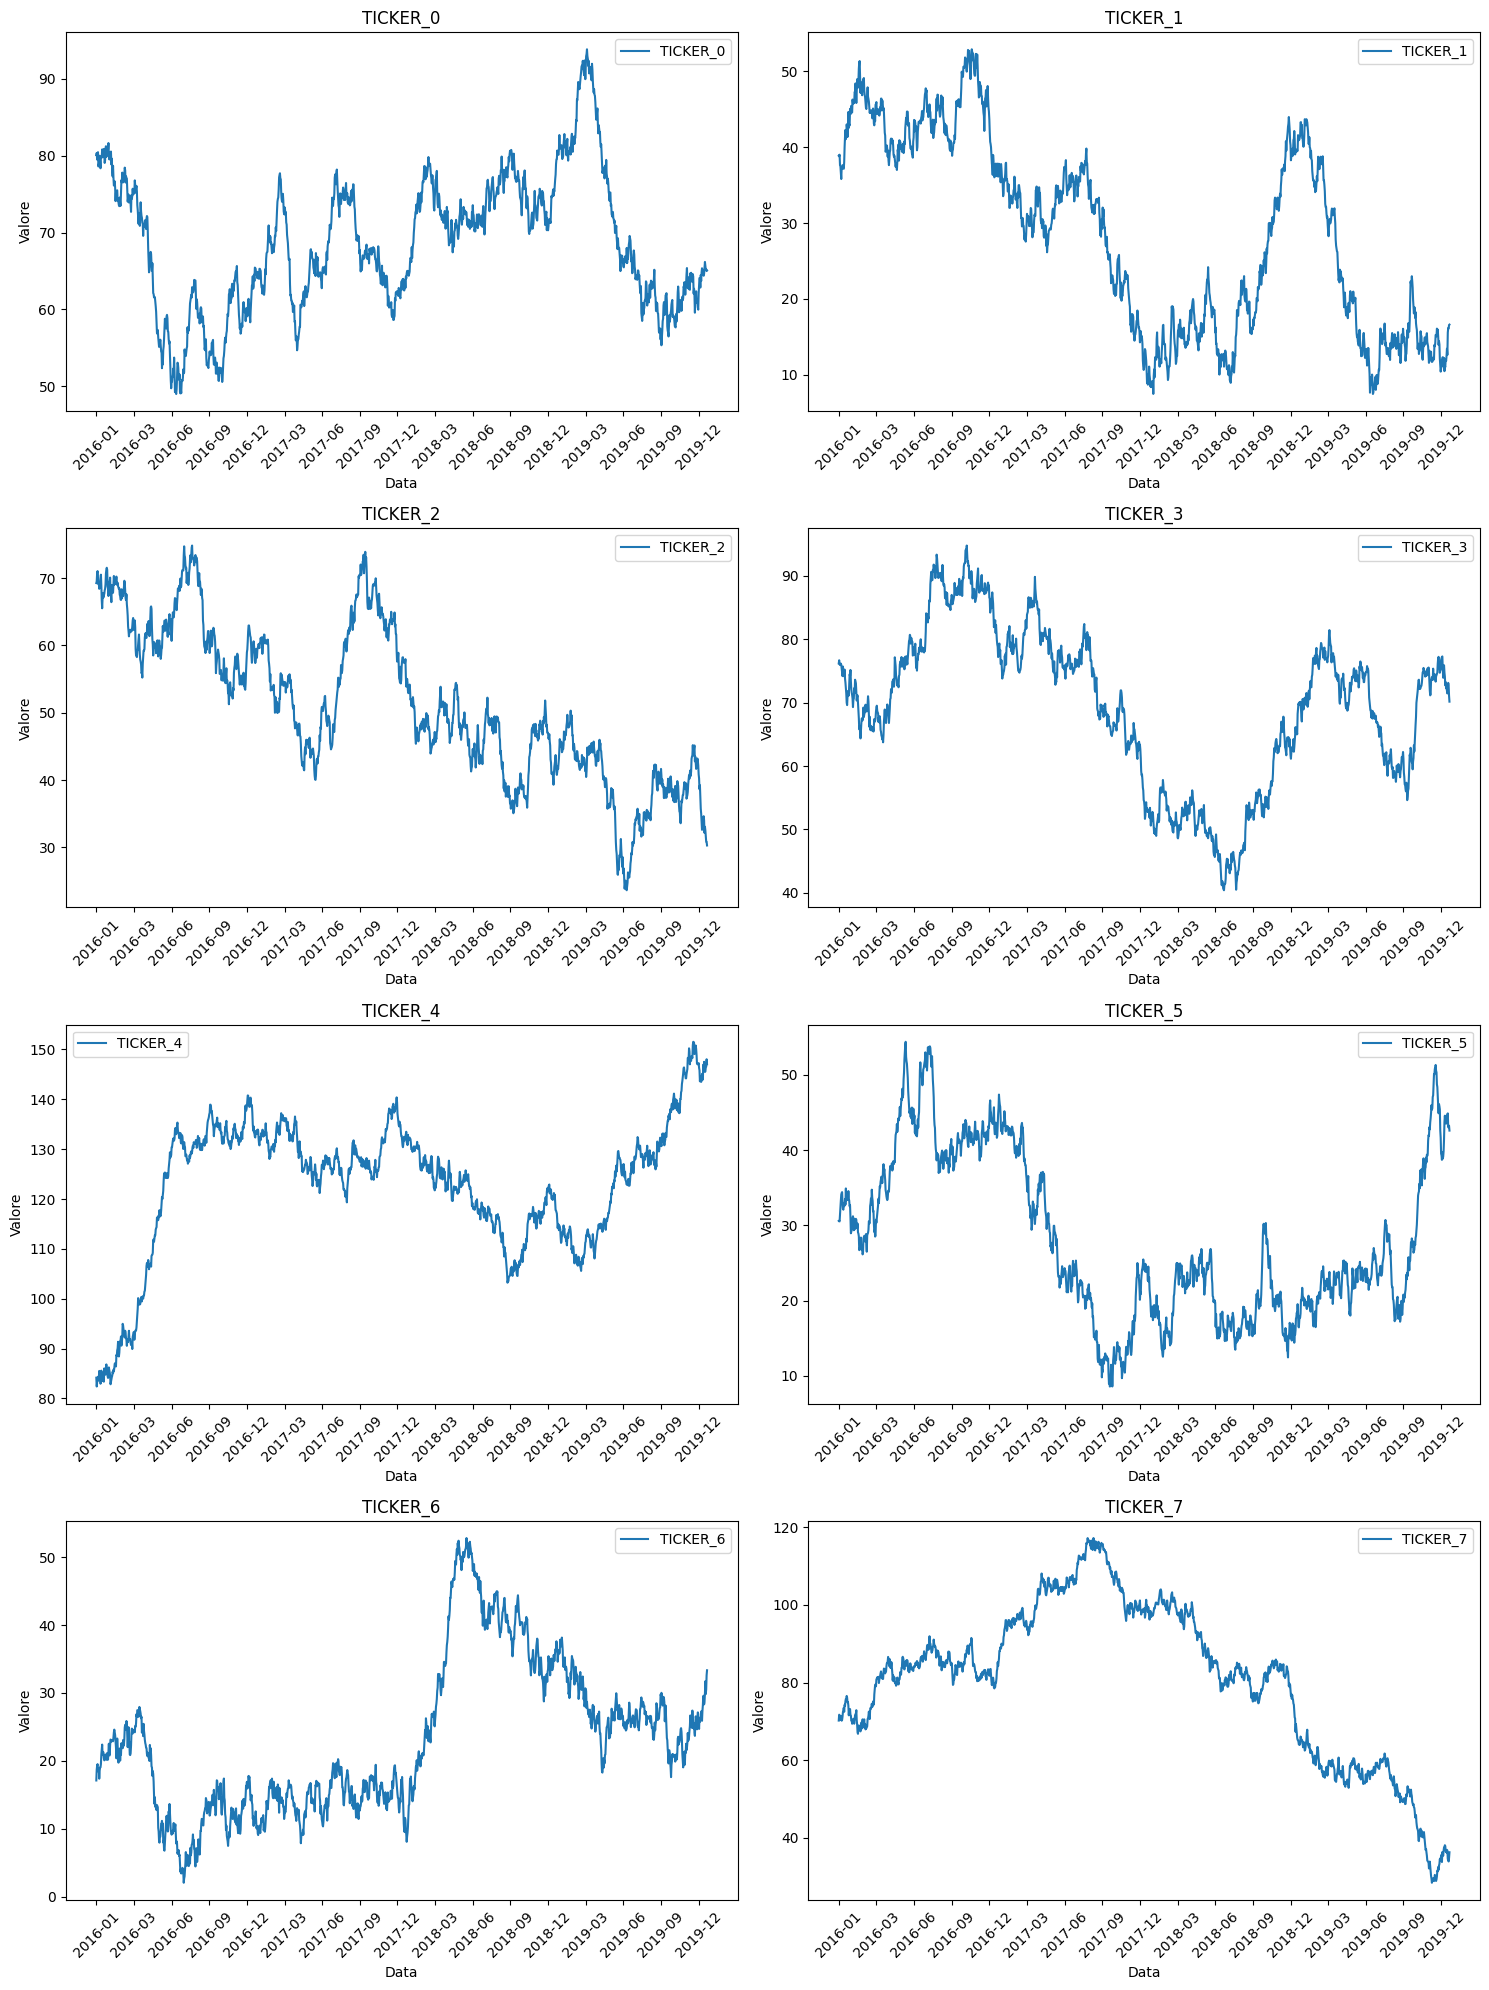

In [434]:
# Funzione per creare i grafici
def create_ticker_plots(stock_data, tickers, dates):
    num_tickers = len(tickers)
    cols = 2  # Numero di colonne nella griglia
    rows = (num_tickers + cols - 1) // cols  # Calcola il numero di righe

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_1d(axes).flatten()  # Assicura che sia un array piatto

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ax.plot(dates, stock_data[i], label=ticker)
        ax.set_title(ticker)
        ax.set_xlabel("Data")
        ax.set_ylabel("Valore")

        # Mostra solo i mesi sull'asse x
        ax.set_xticks(dates[::90])  # Ogni 90 giorni (circa un trimestre)
        ax.set_xticklabels([date.strftime('%Y-%m') for date in dates[::90]], rotation=45)
        ax.legend()

    # Rimuovi eventuali subplot vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_ticker_plots(stock_data, tickers, dates)

## Matrice di covarianza degli assets

In questa cella, eseguiamo i seguenti passaggi:
1. Calcoliamo il vettore medio dei rendimenti periodici (`mu`) utilizzando il metodo `get_period_return_mean_vector` del `data_provider`.
2. Calcoliamo la matrice di covarianza dei rendimenti periodici (`sigma`) utilizzando il metodo `get_period_return_covariance_matrix` del `data_provider`.
3. Creiamo un DataFrame Pandas (`sigma_df`) per la matrice di covarianza, utilizzando i ticker degli asset come indici e colonne.
4. Visualizziamo la matrice di covarianza degli asset utilizzando una heatmap di Seaborn:
   - Impostiamo la dimensione della figura a 8x6 pollici.
   - Utilizziamo `sns.heatmap` per creare la heatmap, con annotazioni dei valori, formato dei numeri a 4 cifre decimali, mappa di colori "coolwarm", barra dei colori, larghezza delle linee di 0.5 e celle quadrate.
   - Impostiamo il titolo della heatmap a "Matrice di covarianza degli assets".
5. Mostriamo la heatmap con `plt.show()`.

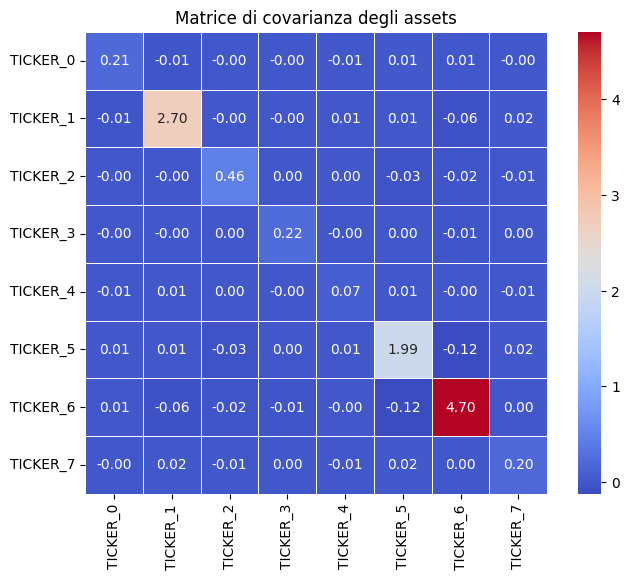

In [435]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

# TODO i valori sono bassisimi e la matrice non rende, dobbiamo tipo moltiplicare tutti i valori per 1000 cosi si visualizzano meglio i dati
sigma *= 1000 # ! soluzione temporanea

sigma_df = pd.DataFrame(sigma, index=tickers, columns=tickers)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

sigma /= 1000 # ! soluzione temporanea

## Configurazione del problema

In questa cella, eseguiamo i seguenti passaggi:

1. Impostiamo il fattore di rischio (`risk_factor`) al valore di 0.2.
2. Definiamo il budget come la metà del numero totale di asset (`assets // 2`), il che significa che selezioneremo il 50% degli asset.
3. Inizializziamo un'istanza di `PortfolioOptimization` con i seguenti parametri:
   - `expected_returns`: il vettore dei rendimenti attesi (`mu`).
   - `covariances`: la matrice di covarianza dei rendimenti (`sigma`).
   - `risk_factor`: il fattore di rischio impostato a 0.2.
   - `budget`: il budget impostato a metà del numero totale di asset.
4. Convertiamo il problema di ottimizzazione del portafoglio in un programma quadratico (`qp`) utilizzando il metodo `to_quadratic_program` dell'istanza `PortfolioOptimization`.

In [436]:
risk_factor = 0.2
# budget = assets // 2 # 50% of the assets
budget = int(assets / 3 * 2)
penalty = budget 
print(f"Assets: {assets}, Budget: {budget}, Penalty: {penalty}, Risk: {risk_factor}")

po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()

Assets: 8, Budget: 5, Penalty: 5, Risk: 0.2


## Configurazione degli algoritmi

In questa cella, configuriamo e inizializziamo gli algoritmi di ottimizzazione del portafoglio che verranno utilizzati per risolvere il problema:

1. **Variabili comuni**:
   - Impostiamo il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Configuriamo l'ottimizzatore `COBYLA` con un numero massimo di iterazioni (`maxiter`) pari a 1000.

2. **Classical**:
   - Inizializziamo l'ottimizzatore classico `Exact Eigensolver` utilizzando `NumPyMinimumEigensolver` e `MinimumEigenOptimizer`.

3. **VQE**:
   - Configuriamo l'ansatz `TwoLocal` con rotazioni `ry` e gate `cz`, con entanglement completo e barriere inserite.
   - Inizializziamo `SamplingVQE` con il campionatore `Sampler`, l'ansatz configurato e l'ottimizzatore `COBYLA`.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `SamplingVQE`.

4. **QAOA**:
   - Impostiamo nuovamente il seme per la generazione casuale utilizzando `algorithm_globals.random_seed`.
   - Inizializziamo `QAOA` con il campionatore `Sampler`, l'ottimizzatore `COBYLA` e un numero di ripetizioni (`reps`) pari a 1.
   - Inizializziamo l'ottimizzatore `MinimumEigenOptimizer` con `QAOA`.

In [437]:
# Variabili comuni per VQE e QAOA
algorithm_globals.random_seed = seed
cobyla = COBYLA()
iter = 250
cobyla.set_options(maxiter=iter)

# scelta dinamica del backend
backend = FakeVigoV2()
if assets > 5:
    backend = FakeTorino()

noise_model = NoiseModel.from_backend(backend)
simulator = AerSimulator(noise_model=noise_model)

### Classico

In [438]:
# Classico
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result_exact = exact_eigensolver.solve(qp)
print_result(result_exact, po)

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 1 1 1 0]	-0.0034		1.0000


### VQE noiseless

In [439]:
# VQE
ry = TwoLocal(assets, "ry", "cz", reps=1, entanglement="full", insert_barriers=True)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes, penalty)
result_svqe = svqe.solve(qp)
print_result(result_svqe, po)

ry_decomposed = ry.decompose()
# ry_decomposed.draw("mpl") # print del circuito

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 1 0 0]	-0.0006		0.1162
[0 1 1 1 0 1 1 0]	-0.0026		0.1016
[0 1 1 1 0 1 0 1]	-0.0002		0.0957
[0 1 0 1 0 1 1 1]	-0.0026		0.0850
[0 1 1 1 1 1 1 0]	-0.0030		0.0703
[0 1 0 1 0 1 1 0]	-0.0030		0.0459
[0 1 0 1 0 1 0 0]	-0.0010		0.0459
[1 1 0 1 0 1 1 0]	-0.0029		0.0381
[0 1 0 1 1 1 0 0]	-0.0014		0.0342
[1 1 1 1 0 1 1 1]	-0.0021		0.0322
[0 1 1 1 1 1 0 1]	-0.0006		0.0303
[1 1 1 1 0 1 0 0]	-0.0006		0.0234
[1 1 0 1 0 1 0 1]	-0.0006		0.0195
[0 1 1 0 0 1 1 1]	-0.0021		0.0166
[1 1 1 1 1 1 0 0]	-0.0009		0.0137
[0 1 0 1 1 1 1 1]	-0.0030		0.0137
[0 1 1 1 1 1 1 1]	-0.0026		0.0137
[1 1 0 1 1 1 1 0]	-0.0033		0.0127
[0 1 1 0 0 1 1 0]	-0.0025		0.0127
[1 1 1 1 0 1 1 0]	-0.0025		0.0098
[0 1 1 1 0 0 0 0]	0.0002		0.0078
[0 0 1 1 0 1 1 0]	-0.0023		0.0078
[1 1 0 1 1 1 1 1]	-0.0029		0.0078
[0 1 0 0 1 1 1 0]	-0.0034

### VQE noisy

In [440]:

ansatz = TwoLocal(
    num_qubits=assets,
    rotation_blocks="ry",
    entanglement_blocks="cz",
    reps=1,
    entanglement="full",
    insert_barriers=True
)
# ansatz.draw("mpl")

decomposed_ansatz = ansatz.decompose()
# decomposed_ansatz.draw("mpl")

transpiled_ansatz = transpile(decomposed_ansatz, simulator)

# transpiled_ansatz_decomposed = transpiled_ansatz.decompose()
# transpiled_ansatz_decomposed.draw("mpl")

# Configura SamplingVQE senza specificare il backend direttamente
svqe_mes_noisy = SamplingVQE(sampler=Sampler(), ansatz=transpiled_ansatz, optimizer=cobyla)

svqe_noisy = MinimumEigenOptimizer(svqe_mes_noisy, penalty)
result_svqe_noisy = svqe_noisy.solve(qp)

print_result(result_svqe_noisy, po)
# transpiled_ry.draw("mpl") # print del circuito

Optimal: selection [0. 1. 1. 1. 1. 1. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 1 0 0]	-0.0006		0.8877
[1 1 1 1 0 1 0 1]	-0.0001		0.0293
[0 1 1 1 1 1 0 0]	-0.0010		0.0186
[1 1 0 1 0 1 0 0]	-0.0010		0.0137
[1 1 1 0 1 1 0 0]	-0.0009		0.0117
[1 0 1 1 0 1 0 0]	-0.0003		0.0098
[1 1 1 1 1 0 0 0]	-0.0001		0.0088
[1 1 1 1 0 1 1 0]	-0.0025		0.0068
[0 1 1 1 0 1 0 0]	-0.0006		0.0029
[1 1 1 1 1 1 0 0]	-0.0009		0.0020
[0 1 0 1 1 1 0 0]	-0.0014		0.0020
[1 0 1 1 0 1 0 1]	0.0001		0.0010
[0 1 1 1 0 0 0 0]	0.0002		0.0010
[0 1 1 0 0 1 0 0]	-0.0006		0.0010
[0 1 1 1 0 1 0 1]	-0.0002		0.0010
[0 1 1 0 1 1 0 0]	-0.0010		0.0010
[0 1 1 1 1 1 1 0]	-0.0030		0.0010
[1 1 1 0 0 1 0 0]	-0.0005		0.0010


### QAOA noiseless

In [441]:
# QAOA
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
result = qaoa.solve(qp)

decomposed_circuit = qaoa_mes.ansatz.decompose()
print_result(result, po)
# decomposed_circuit.draw("mpl") # print del circuito

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 1 0 1]	-0.0006		0.0146
[0 0 1 0 0 0 0 0]	0.0004		0.0137
[1 0 0 1 1 0 1 1]	-0.0018		0.0137
[1 0 0 0 0 0 0 0]	0.0001		0.0127
[1 1 1 0 0 0 0 0]	0.0003		0.0127
[1 1 1 0 0 1 1 0]	-0.0025		0.0117
[1 1 1 0 1 1 1 1]	-0.0025		0.0117
[0 1 1 1 1 1 0 0]	-0.0010		0.0107
[1 0 1 1 1 1 1 1]	-0.0022		0.0107
[1 0 1 0 0 0 1 0]	-0.0013		0.0107
[0 0 0 1 0 0 1 1]	-0.0015		0.0107
[1 1 1 1 1 0 1 1]	-0.0016		0.0107
[0 1 0 0 1 1 0 0]	-0.0014		0.0107
[0 0 0 0 0 0 1 0]	-0.0018		0.0107
[1 0 1 1 0 0 1 1]	-0.0010		0.0098
[1 0 1 0 1 0 0 0]	0.0001		0.0098
[0 1 0 0 0 0 0 0]	-0.0002		0.0098
[1 1 1 0 1 0 0 1]	0.0003		0.0098
[0 1 0 1 1 0 0 0]	-0.0006		0.0098
[1 1 0 0 0 0 0 1]	0.0003		0.0098
[1 1 0 0 0 0 1 0]	-0.0020		0.0098
[1 1 1 0 1 0 1 0]	-0.0020		0.0098
[0 0 0 0 1 0 1 1]	-0.0019		0.0098
[1 1 1 1 1 1 0 1]	-0.0005		0.0

## QAOA noisy

In [442]:
# QAOA noisy
qaoa_mes_noisy = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa_noisy = MinimumEigenOptimizer(qaoa_mes_noisy, penalty)
_ = qaoa_noisy.solve(qp)

decomposed_circuit_noisy = qaoa_mes_noisy.ansatz.decompose()
transpiled_circuit_noisy = transpile(decomposed_circuit_noisy, simulator)

qaoa_mes_noisy.ansatz = transpiled_circuit_noisy
qaoa_noisy = MinimumEigenOptimizer(qaoa_mes_noisy, penalty)
result_decomposed = qaoa_noisy.solve(qp)
print_result(result_decomposed, po)


Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 1 0 1 1]	-0.0020		0.0137
[1 1 0 1 1 0 1 0]	-0.0024		0.0127
[0 0 1 0 1 0 1 0]	-0.0018		0.0127
[1 0 0 0 1 0 0 1]	0.0001		0.0117
[1 0 0 0 0 0 1 1]	-0.0014		0.0117
[0 0 1 1 1 1 0 1]	-0.0004		0.0117
[0 0 0 1 0 0 0 0]	-0.0000		0.0117
[0 1 0 0 0 0 1 1]	-0.0017		0.0107
[0 1 0 1 0 0 1 0]	-0.0021		0.0107
[1 1 1 0 0 0 0 0]	0.0003		0.0107
[1 0 0 1 0 1 1 1]	-0.0022		0.0107
[1 1 0 0 1 1 1 0]	-0.0033		0.0107
[0 1 0 0 1 0 0 1]	-0.0002		0.0107
[1 1 0 0 0 1 0 0]	-0.0010		0.0107
[1 0 1 1 1 0 1 0]	-0.0018		0.0107
[1 1 1 0 0 1 1 0]	-0.0025		0.0098
[1 0 1 0 1 1 0 1]	-0.0003		0.0098
[0 0 1 0 1 1 0 0]	-0.0008		0.0098
[1 1 0 1 0 1 0 1]	-0.0006		0.0098
[1 1 1 1 1 1 1 0]	-0.0029		0.0098
[0 0 1 0 0 0 1 1]	-0.0010		0.0098
[1 1 0 1 1 1 0 0]	-0.0014		0.0088
[0 1 1 0 0 0 0 1]	0.0006		0.0088
[1 0 1 1 0 0 1 1]	-0.0010		

### QAOA noiseless (versione non ottimizzata)

In [443]:
# Definizione dei parametri
num_assets = assets  # Esempio con 4 asset
p = 20 * num_assets 

# Creazione dei parametri per beta e gamma
beta = Parameter('beta')
gamma = Parameter('gamma')

# Creazione del circuito per lo stato iniziale
qc_i = QuantumCircuit(num_assets)
qc_i.h(range(num_assets))

# Creazione del circuito mixer
qc_m = QuantumCircuit(num_assets)

# Implementazione dell'operatore a due corpi (parte gamma)
for i in range(num_assets - 1):
    next = (i + 1) % num_assets
    
    # Prima parte del mixer
    qc_m.ry(-np.pi/2, i)
    qc_m.ry(-np.pi/2, next)
    qc_m.cx(i, next)
    qc_m.rz(-2 * gamma, next)
    qc_m.cx(i, next)
    qc_m.ry(np.pi/2, i)
    qc_m.ry(np.pi/2, next)

# Aggiunta della barriera per chiarezza
qc_m.barrier()

# Implementazione dell'operatore ad un corpo (parte beta)
qc_m.rx(-np.pi/2, range(num_assets))
qc_m.rz(2*beta, range(num_assets))
qc_m.rx(np.pi/2, range(num_assets))

# Funzione per creare il circuito QAOA completo
def create_qaoa_circuit(num_layers):
    qc_complete = QuantumCircuit(num_assets)
    qc_complete.compose(qc_i, inplace=True)
    
    for _ in range(num_layers):
        qc_complete.compose(qc_m, inplace=True)
    
    qc_complete.measure_all()
    return qc_complete

# Creazione del circuito con un layer per visualizzazione
qaoa_circuit = create_qaoa_circuit(1)

# ! da decommentare
# qaoa_mes = QAOA(sampler=Sampler(), 
#                 optimizer=cobyla, 
#                 reps=p,
#                 initial_state=qc_i,
#                 mixer=qc_m)
# qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
# qaoa.solve(qp)
# qaoa_circuit.draw("mpl") # print del circuito

## Esecuzione degli algoritmi di ottimizzazione del portafoglio e visualizzazione dei risultati
La selezione di ogni asset è rappresentata da un valore binario (1 = selezionato, 0 = non selezionato).

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo i parametri iniziali come `n_repeats` e `risk_factor`.
2. Inizializziamo le matrici per memorizzare le selezioni degli asset per ciascun algoritmo (`QAOA`, `SVQE`, `Exact Eigensolver`).
3. Generiamo tutte le possibili combinazioni di selezione degli asset e inizializziamo un dizionario per contare le occorrenze di ciascuna combinazione per ogni algoritmo.
4. Creiamo un'istanza di `PortfolioOptimization` e convertiamo il problema in un programma quadratico.
5. Eseguiamo ciascun algoritmo `n_repeats` volte, memorizzando le selezioni degli asset e aggiornando i contatori delle combinazioni.
6. Calcoliamo il numero totale di selezioni per ciascun asset per ogni algoritmo.
7. Filtriamo le combinazioni con valore 0 per visualizzare solo quelle con almeno una selezione.
8. Creiamo una griglia di grafici (1 riga e 3 colonne) per visualizzare la distribuzione delle selezioni degli asset per ciascun algoritmo.
9. Creiamo un grafico combinato per visualizzare la distribuzione delle selezioni degli asset per tutti gli algoritmi.
10. Creiamo un grafico a barre per visualizzare la frequenza delle combinazioni di selezione degli asset per ciascun algoritmo, utilizzando una scala logaritmica in base 2 per l'asse delle y.

In [444]:
selections_qaoa = np.zeros((n_repeats, len(tickers)))
selections_svqe = np.zeros((n_repeats, len(tickers)))
selections_exact_eigensolver = np.zeros((n_repeats, len(tickers)))

selections_qaoa_noisy = np.zeros((n_repeats, len(tickers)))
selections_svqe_noisy = np.zeros((n_repeats, len(tickers)))

all_combinations = list(itertools.product([0, 1], repeat=assets))

combinations_count = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
    'exact': {comb: 0 for comb in all_combinations}
}

combinations_count_noisy = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
}

po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    # noiseless
    result_qaoa = qaoa.solve(qp)
    selections_qaoa[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe.solve(qp)
    selections_svqe[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    result_exact = exact_eigensolver.solve(qp)
    selections_exact_eigensolver[i] = result_exact.x
    selection_exact = tuple(result_exact.x)

    combinations_count['qaoa'][selection_qaoa] += 1
    combinations_count['svqe'][selection_svqe] += 1
    combinations_count['exact'][selection_exact] += 1
    
    # noisy
    result_qaoa = qaoa_noisy.solve(qp)
    selections_qaoa_noisy[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe_noisy.solve(qp)
    selections_svqe_noisy[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    combinations_count_noisy['qaoa'][selection_qaoa] += 1
    combinations_count_noisy['svqe'][selection_svqe] += 1

# noiseless
selection_counts_qaoa = np.sum(selections_qaoa, axis=0)
selection_counts_svqe = np.sum(selections_svqe, axis=0)
selection_counts_exact_eigensolver = np.sum(selections_exact_eigensolver, axis=0)

combinations = list(combinations_count['qaoa'].keys())
frequencies_qaoa = list(combinations_count['qaoa'].values())
frequencies_svqe = list(combinations_count['svqe'].values())
frequencies_exact = list(combinations_count['exact'].values())

# Filtra le combinazioni con valore 0
filtered_combinations = []
filtered_frequencies_qaoa = []
filtered_frequencies_svqe = []
filtered_frequencies_exact = []

for comb, fq, fs, fe in zip(combinations, frequencies_qaoa, frequencies_svqe, frequencies_exact):
    if fq > 0 or fs > 0 or fe > 0:
        filtered_combinations.append(comb)
        filtered_frequencies_qaoa.append(fq)
        filtered_frequencies_svqe.append(fs)
        filtered_frequencies_exact.append(fe)

# noisy
selection_counts_qaoa_noisy = np.sum(selections_qaoa_noisy, axis=0)
selection_counts_svqe_noisy = np.sum(selections_svqe_noisy, axis=0)
combinations_noisy = list(combinations_count_noisy['qaoa'].keys())
frequencies_qaoa_noisy = list(combinations_count_noisy['qaoa'].values())
frequencies_svqe_noisy = list(combinations_count_noisy['svqe'].values())

# Filtra le combinazioni con valore 0
filtered_combinations_noisy = []
filtered_frequencies_qaoa_noisy = []
filtered_frequencies_svqe_noisy = []
filtered_frequencies_exact_x_noise = []

for comb, fq, fs, fe in zip(combinations_noisy, frequencies_qaoa_noisy, frequencies_svqe_noisy, frequencies_exact):
# for comb, fq, fs in zip(combinations_noisy, frequencies_qaoa_noisy, frequencies_svqe_noisy):
    if fq > 0 or fs > 0:
        filtered_combinations_noisy.append(comb)
        filtered_frequencies_qaoa_noisy.append(fq)
        filtered_frequencies_svqe_noisy.append(fs)
        filtered_frequencies_exact_x_noise.append(fe)
        
# noiseless vs noisy
# filtered_combinations_vs = []
filtered_combinations_vs = list(set(filtered_combinations_noisy) | set(filtered_combinations))
# filtered_frequencies_qaoa_vs = []
filtered_frequencies_qaoa_vs = list(set(filtered_frequencies_qaoa_noisy) | set(filtered_frequencies_qaoa))
# filtered_frequencies_svqe_vs = []
filtered_frequencies_svqe_vs = list(set(filtered_frequencies_svqe_noisy) | set(filtered_frequencies_svqe))

### Noiseless plot

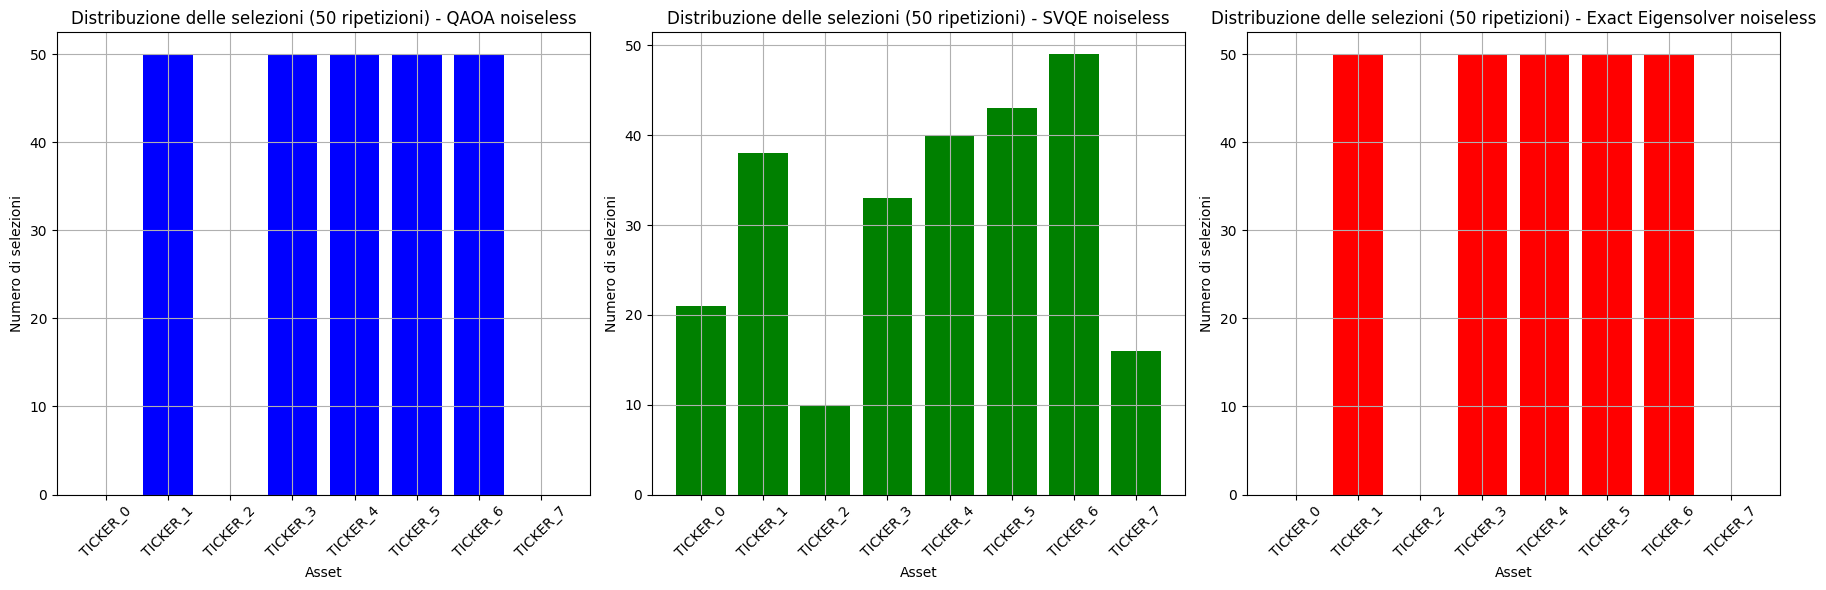

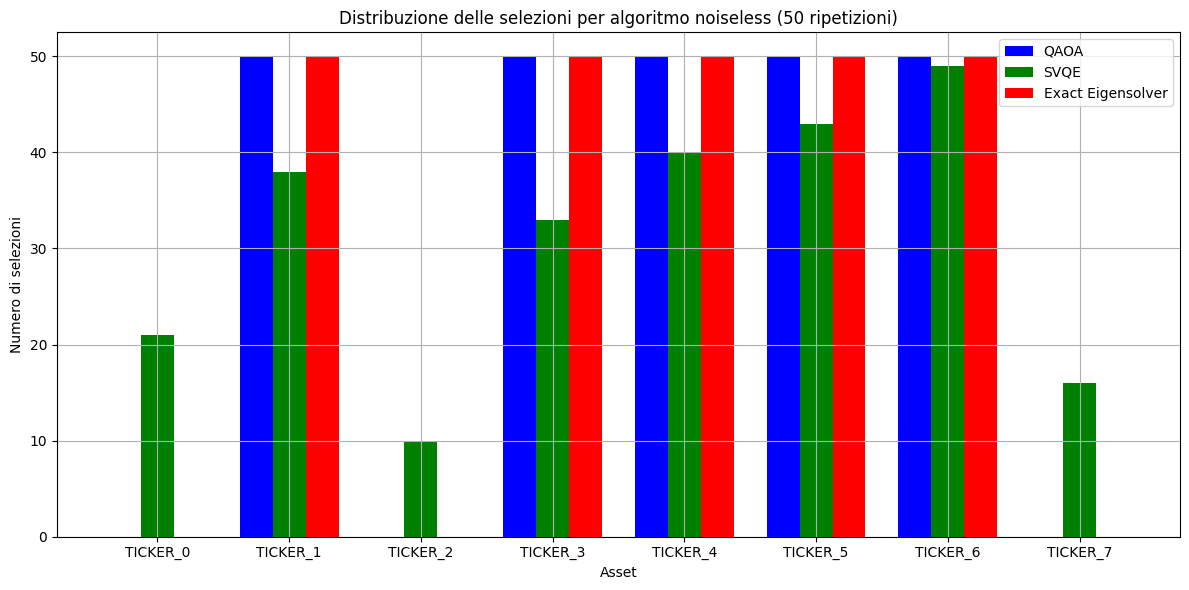

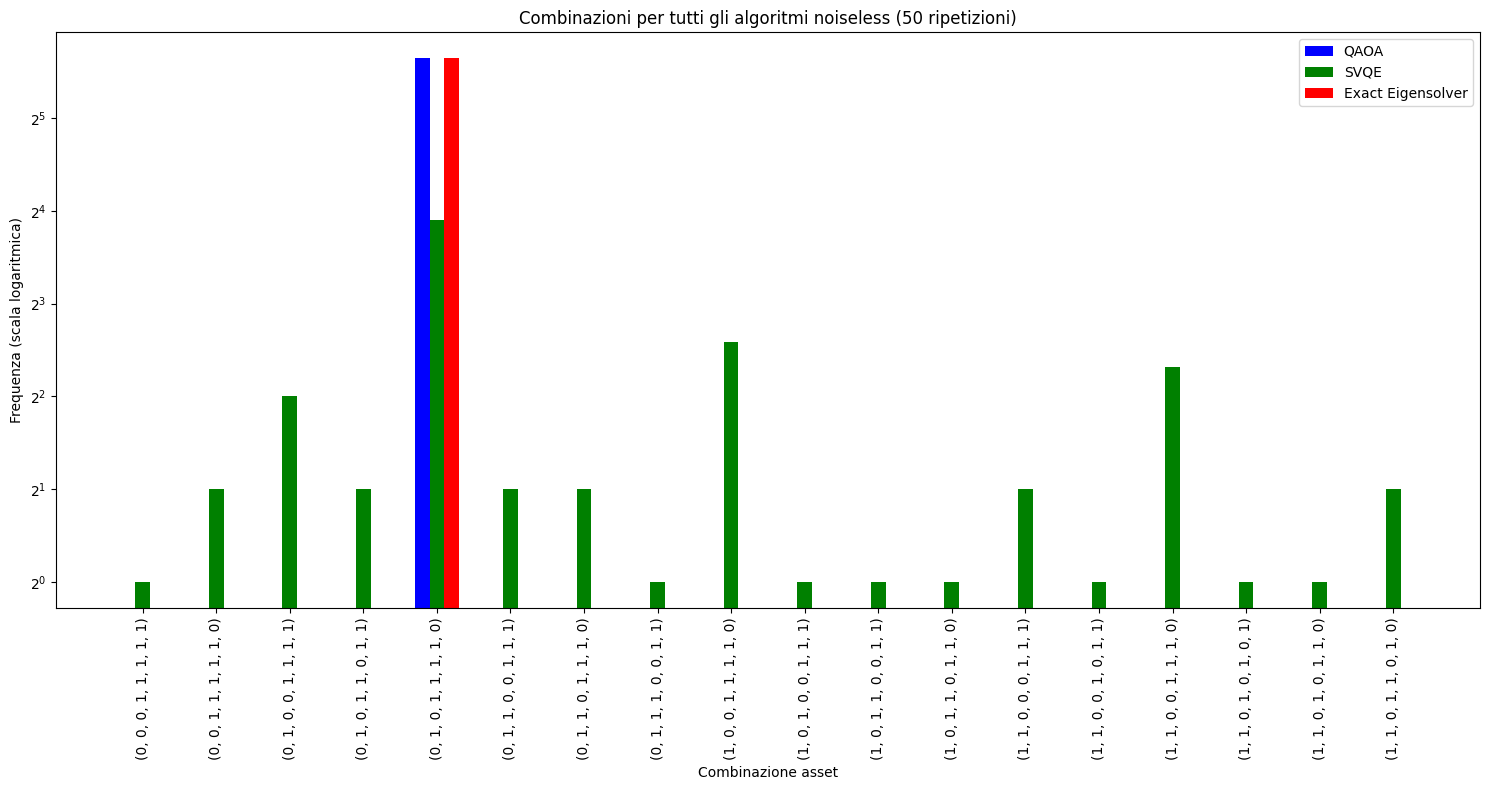

In [445]:
## Noiseless
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per QAOA noiseless
axs[0].bar(tickers, selection_counts_qaoa, color=qaua_color)
axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noiseless")
axs[0].set_xlabel("Asset")
axs[0].set_ylabel("Numero di selezioni")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Grafico per SVQE noiseless
axs[1].bar(tickers, selection_counts_svqe, color=svqe_color)
axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noiseless")
axs[1].set_xlabel("Asset")
axs[1].set_ylabel("Numero di selezioni")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Grafico per Exact Eigensolver
axs[2].bar(tickers, selection_counts_exact_eigensolver, color=exact_color)
axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver noiseless")
axs[2].set_xlabel("Asset")
axs[2].set_ylabel("Numero di selezioni")
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Grafico delle selezioni
width = 0.25
x = np.arange(len(tickers))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa, width, color=qaua_color, label='QAOA')
plt.bar(x, selection_counts_svqe, width, color=svqe_color, label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

plt.title(f"Distribuzione delle selezioni per algoritmo noiseless ({n_repeats} ripetizioni)")
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, tickers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Grafico combinazioni
n_combinations = len(filtered_combinations)
indice = np.arange(n_combinations)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))

# Barre per QAOA
plt.bar(indice - larghezza, filtered_frequencies_qaoa, larghezza, color=qaua_color, label='QAOA')
# Barre per SVQE
plt.bar(indice, filtered_frequencies_svqe, larghezza, color=svqe_color, label='SVQE')
# Barre per Exact Eigensolver
plt.bar(indice + larghezza, filtered_frequencies_exact, larghezza, color=exact_color, label='Exact Eigensolver')

plt.yscale('log', base=2)
plt.title(f"Combinazioni per tutti gli algoritmi noiseless ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

### Noisy plot

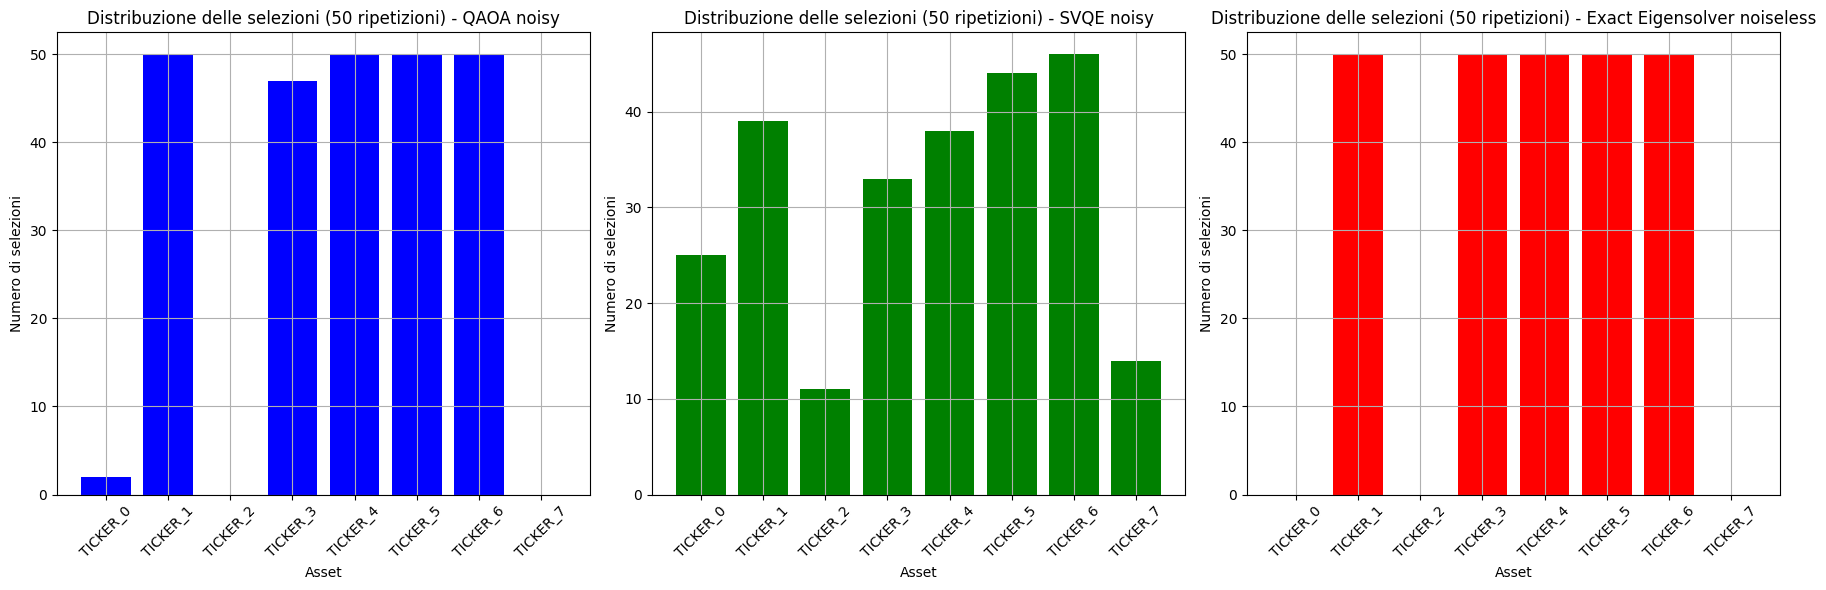

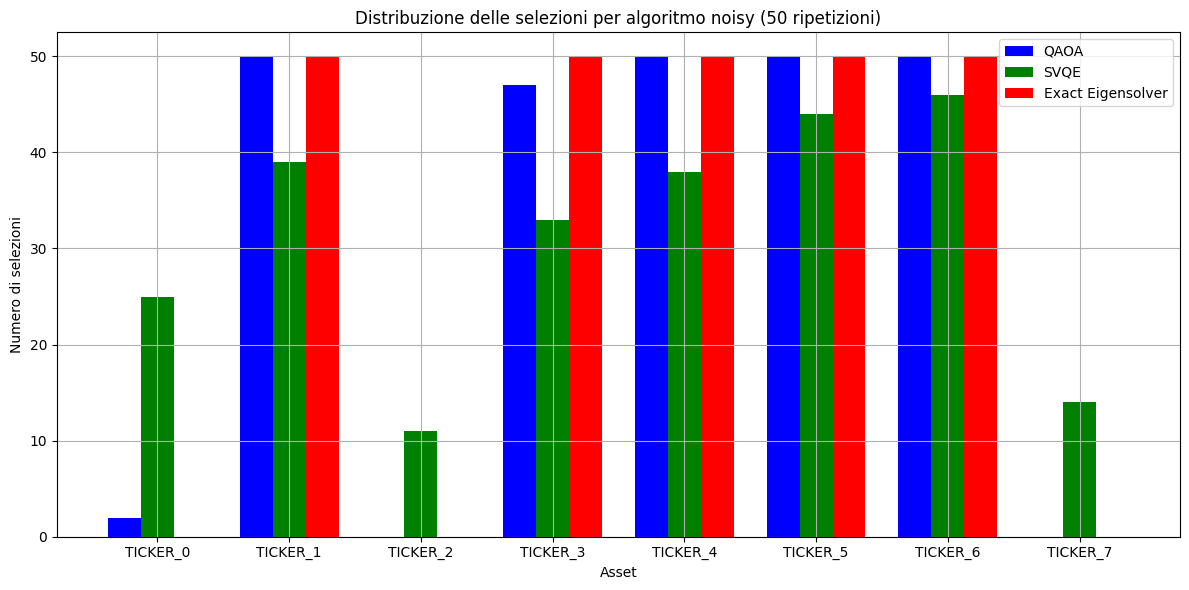

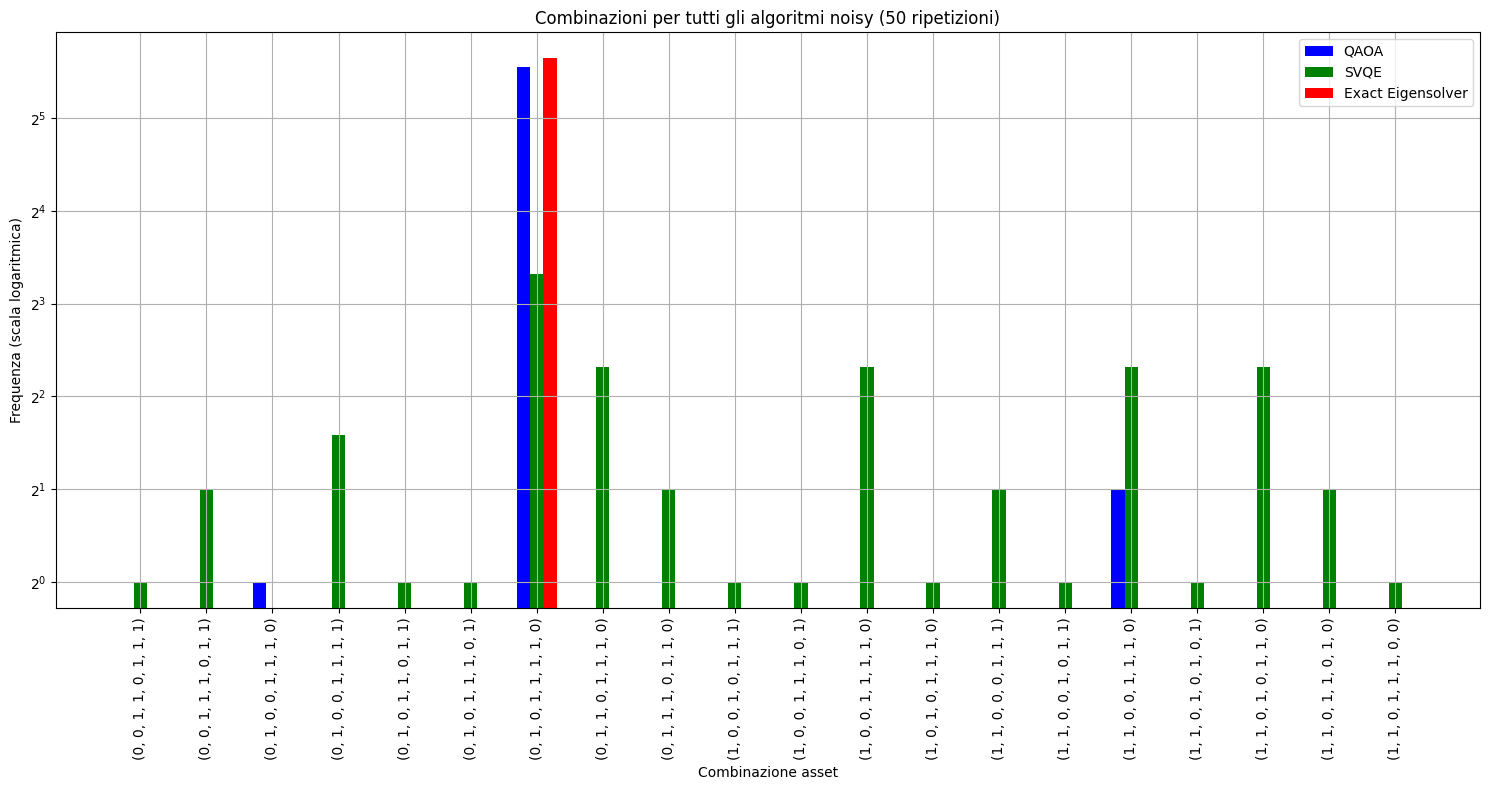

In [446]:
## Noisy
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per QAOA noisy
axs[0].bar(tickers, selection_counts_qaoa_noisy, color=qaua_color)
axs[0].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - QAOA noisy")
axs[0].set_xlabel("Asset")
axs[0].set_ylabel("Numero di selezioni")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Grafico per SVQE noisy
axs[1].bar(tickers, selection_counts_svqe_noisy, color=svqe_color)
axs[1].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - SVQE noisy")
axs[1].set_xlabel("Asset")
axs[1].set_ylabel("Numero di selezioni")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Grafico per Exact Eigensolver
axs[2].bar(tickers, selection_counts_exact_eigensolver, color=exact_color)
axs[2].set_title(f"Distribuzione delle selezioni ({n_repeats} ripetizioni) - Exact Eigensolver noiseless")
axs[2].set_xlabel("Asset")
axs[2].set_ylabel("Numero di selezioni")
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Grafico delle selezioni
width = 0.25
x = np.arange(len(tickers))

plt.figure(figsize=(12, 6))
plt.bar(x - width, selection_counts_qaoa_noisy, width, color=qaua_color, label='QAOA')
plt.bar(x, selection_counts_svqe_noisy, width, color=svqe_color, label='SVQE')
plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

plt.title(f"Distribuzione delle selezioni per algoritmo noisy ({n_repeats} ripetizioni)")
plt.xlabel('Asset')
plt.ylabel('Numero di selezioni')
plt.xticks(x, tickers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Grafico combinazioni
n_combinations_noisy = len(filtered_combinations_noisy)
indice = np.arange(n_combinations_noisy)
larghezza = 0.2  # Larghezza delle barre

plt.figure(figsize=(15, 8))

# Barre per QAOA
plt.bar(indice - larghezza, filtered_frequencies_qaoa_noisy, larghezza, color=qaua_color, label='QAOA')
# Barre per SVQE
plt.bar(indice, filtered_frequencies_svqe_noisy, larghezza, color=svqe_color, label='SVQE')
# Barre per Exact Eigensolver
plt.bar(indice + larghezza, filtered_frequencies_exact_x_noise, larghezza, color=exact_color, label='Exact Eigensolver')

plt.yscale('log', base=2)
plt.title(f"Combinazioni per tutti gli algoritmi noisy ({n_repeats} ripetizioni)")
plt.xlabel("Combinazione asset")
plt.ylabel("Frequenza (scala logaritmica)")
plt.xticks(indice, [str(comb) for comb in filtered_combinations_noisy], rotation=90)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Confronto algoritmi (noiseless vs noisy)

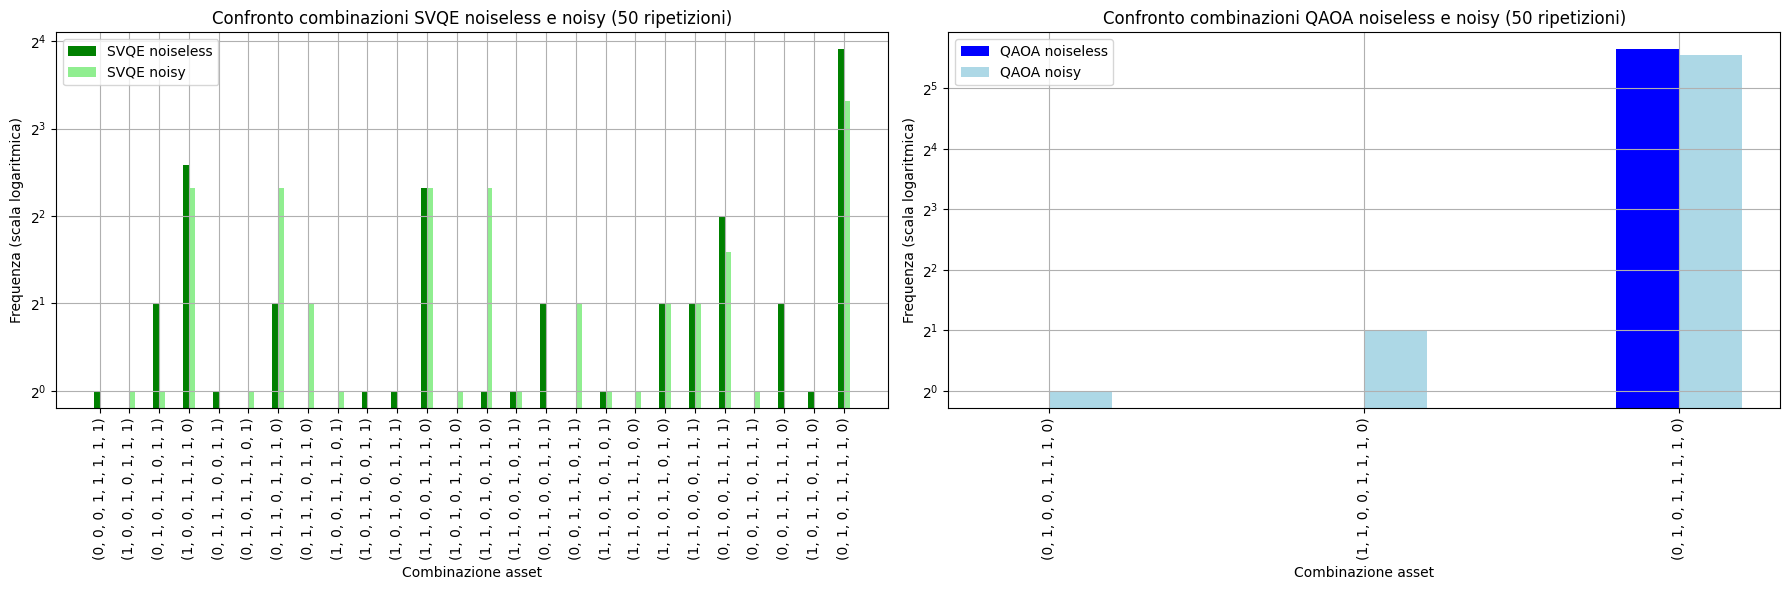

In [447]:
### Confronto algoritmi

# Estrazioni combinazioni interessate
all_combinations_vs = list(set(filtered_combinations_noisy).union(set(filtered_combinations)))

filtered_vqe_vs = []
filtered_vqe_noisy_vs = []
filtered_qaoa_vs = []
filtered_qaoa_noisy_vs = []

filtered_combinations_vqe_vs = []
filtered_combinations_qaoa_vs = []
filtered_frequencies_vqe_vs = []
filtered_frequencies_vqe_noisy_vs = []
filtered_frequencies_qaoa_vs = []
filtered_frequencies_qaoa_noisy_vs = []

# Filtra le combinazioni senza soluzioni
for comb in all_combinations_vs:
    fq_vqe = filtered_frequencies_svqe[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_qaoa = filtered_frequencies_qaoa[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_vqe_noisy = filtered_frequencies_svqe_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0
    fq_qaoa_noisy = filtered_frequencies_qaoa_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0

    if fq_vqe > 0 or fq_vqe_noisy > 0:
        filtered_combinations_vqe_vs.append(comb)
        filtered_frequencies_vqe_vs.append(fq_vqe)
        filtered_frequencies_vqe_noisy_vs.append(fq_vqe_noisy)
    
    if fq_qaoa > 0 or fq_qaoa_noisy > 0:
        filtered_combinations_qaoa_vs.append(comb)
        filtered_frequencies_qaoa_vs.append(fq_qaoa)
        filtered_frequencies_qaoa_noisy_vs.append(fq_qaoa_noisy)

### Grafico combinazioni algoritmi a confronto

n_combinations_vs = len(filtered_combinations_vqe_vs)
indice = np.arange(n_combinations_vs)
larghezza = 0.2  # Larghezza delle barre

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# Confronto combinazioni VQE noiseless e VQE noisy
axs[0].bar(indice - larghezza/2, filtered_frequencies_vqe_vs, larghezza, color='green', label='SVQE noiseless')
axs[0].bar(indice + larghezza/2, filtered_frequencies_vqe_noisy_vs, larghezza, color='lightgreen', label='SVQE noisy')
axs[0].set_yscale('log', base=2)
axs[0].set_title(f"Confronto combinazioni SVQE noiseless e noisy ({n_repeats} ripetizioni)")
axs[0].set_xlabel("Combinazione asset")
axs[0].set_ylabel("Frequenza (scala logaritmica)")
axs[0].set_xticks(indice)
axs[0].set_xticklabels([str(comb) for comb in filtered_combinations_vqe_vs], rotation=90)
axs[0].legend()
axs[0].grid(True)


n_combinations_vs = len(filtered_combinations_qaoa_vs)
indice = np.arange(n_combinations_vs)
larghezza = 0.2  # Larghezza delle barre

# Confronto combinazioni QAOA noiseless e QAOA noisy
axs[1].bar(indice - larghezza/2, filtered_frequencies_qaoa_vs, larghezza, color='blue', label='QAOA noiseless')
axs[1].bar(indice + larghezza/2, filtered_frequencies_qaoa_noisy_vs, larghezza, color='lightblue', label='QAOA noisy')
axs[1].set_yscale('log', base=2)
axs[1].set_title(f"Confronto combinazioni QAOA noiseless e noisy ({n_repeats} ripetizioni)")
axs[1].set_xlabel("Combinazione asset")
axs[1].set_ylabel("Frequenza (scala logaritmica)")
axs[1].set_xticks(indice)
axs[1].set_xticklabels([str(comb) for comb in filtered_combinations_qaoa_vs], rotation=90)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Analisi del rischio vs ritorno atteso per diversi algoritmi

In questa cella, eseguiamo i seguenti passaggi:

1. Definiamo una serie di valori di rischio (`risks`) utilizzando `np.linspace` per generare 20 valori equidistanti tra 0 e 1.
2. Calcoliamo i valori ottimali per ciascun valore di rischio utilizzando i tre algoritmi di ottimizzazione del portafoglio (`QAOA`, `SVQE`, `Exact Eigensolver`):
   - **QAOA**:
     - Inizializziamo una lista vuota (`values_per_risk_qaoa`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `qaoa` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **SVQE**:
     - Inizializziamo una lista vuota (`values_per_risk_svqe`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `svqe` e memorizziamo il valore ottimale (`result.fval`) nella lista.
   - **Exact Eigensolver**:
     - Inizializziamo una lista vuota (`values_exact_eigensolver`) per memorizzare i valori ottimali.
     - Per ciascun valore di rischio, creiamo un'istanza di `PortfolioOptimization` con i parametri appropriati e convertiamo il problema in un programma quadratico (`qp`).
     - Risolviamo il problema utilizzando `exact_eigensolver` e memorizziamo il valore ottimale (`result.fval`) nella lista.
3. Creiamo un grafico per visualizzare la relazione tra il fattore di rischio e il valore ottimale per ciascun algoritmo:
   - Utilizziamo `plt.plot` per tracciare i valori ottimali in funzione del fattore di rischio per `QAOA`, `SVQE` e `Exact Eigensolver`, con diversi marker e colori per ciascun algoritmo.
   - Impostiamo il titolo del grafico a "Rischio vs ritorno atteso per diversi algoritmi".
   - Etichettiamo gli assi x e y rispettivamente come "Fattore di rischio" e "Valore ottimale".
   - Aggiungiamo una griglia e una legenda per migliorare la leggibilità del grafico.
   - Utilizziamo `plt.tight_layout` per ottimizzare il layout del grafico e `plt.show` per visualizzarlo.

## Stampa delle informazioni del modello

In [448]:
def print_backend_info(backend):
    print("\n=== Informazioni sul Backend ===\n")
    print(f"Nome: {backend.name}")
    print(f"Descrizione: {backend.description}")
    print(f"Versione: {backend.version}")
    print(f"Numero di Qubit: {backend.num_qubits}")
    config = backend.configuration()
    print(f"Istruzioni supportate:")
    for instruction in config.supported_instructions:
        print(f"- {instruction}")
    print()
    

def print_noise_model_info(noise_model):
    print("\n=== Informazioni sul modello di rumore ===\n")
    print(noise_model)
    # TODO aggiungere informazioni sull'errore sul singolo qubit

print_backend_info(backend)
print_noise_model_info(noise_model)


=== Informazioni sul Backend ===

Nome: fake_torino
Descrizione: 133 qubit device
Versione: 2
Numero di Qubit: 133
Istruzioni supportate:
- cz
- id
- delay
- measure
- reset
- rz
- sx
- x
- if_else
- for_loop
- switch_case


=== Informazioni sul modello di rumore ===

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'reset', 'x', 'sx', 'cz']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124

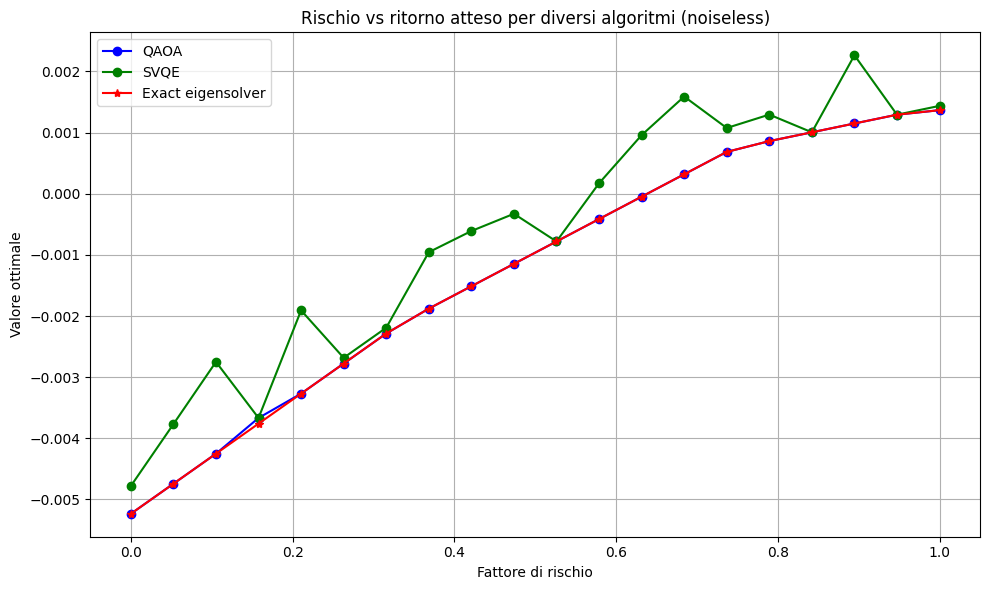

In [449]:
risks = np.linspace(0, 1, 20)

# Risultati per QAOA
values_per_risk_qaoa = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = qaoa.solve(qp)
    values_per_risk_qaoa.append(result.fval)

# Risultati per SVQE
values_per_risk_svqe = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = svqe.solve(qp)
    values_per_risk_svqe.append(result.fval)

# Risultati per Exact Eigensolver
values_exact_eigensolver = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values_exact_eigensolver.append(result.fval)

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plot per QAOA
plt.plot(risks, values_per_risk_qaoa, marker='o', linestyle='-', color=qaua_color, label='QAOA')

# Plot per SVQE
plt.plot(risks, values_per_risk_svqe, marker='o', linestyle='-', color=svqe_color, label='SVQE')

# Plot per Exact Eigensolver
plt.plot(risks, values_exact_eigensolver, marker='*', linestyle='-', color=exact_color, label='Exact eigensolver')

plt.title("Rischio vs ritorno atteso per diversi algoritmi (noiseless)")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()